In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


In [5]:
df_movies = pd.read_csv('titles.csv')
df_movies.head(2)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179


In [6]:
df_movies = df_movies.drop_duplicates()

In [8]:
df_movies['production_countries']

0             ['US']
1             ['US']
2             ['US']
3             ['GB']
4       ['GB', 'US']
            ...     
5845          ['NG']
5846              []
5847          ['CO']
5848          ['US']
5849              []
Name: production_countries, Length: 5850, dtype: object

In [9]:
df_movies['production_countries'] = df_movies['production_countries'].str.replace(r"\[", '', regex=True).str.replace(r"'", '', regex=True).str.replace(r"\]", '', regex=True)
df_movies['lead_prod_country'] = df_movies['production_countries'].str.split(',').str[0]
df_movies['prod_countries_cnt'] = df_movies['production_countries'].str.split(',').str.len()
df_movies['lead_prod_country'] = df_movies['lead_prod_country'].replace('', np.nan)

In [10]:
df_movies['lead_prod_country']

0        US
1        US
2        US
3        GB
4        GB
       ... 
5845     NG
5846    NaN
5847     CO
5848     US
5849    NaN
Name: lead_prod_country, Length: 5850, dtype: object

In [11]:
df_movies['genres'] = df_movies['genres'].str.replace(r"\[", '', regex=True).str.replace(r"'", '', regex=True).str.replace(r"\]", '', regex=True)
df_movies['main_genre'] = df_movies['genres'].str.split(',').str[0]
df_movies['main_genre'] = df_movies['main_genre'].replace('', np.nan)

In [12]:
df_movies['main_genre']

0       documentation
1               drama
2               drama
3             fantasy
4                 war
            ...      
5845          romance
5846            drama
5847           comedy
5848              NaN
5849           family
Name: main_genre, Length: 5850, dtype: object

In [13]:
df_movies.drop(['genres', 'production_countries'], axis=1, inplace=True)

In [14]:
df_movies.isnull().sum()

id                       0
title                    1
type                     0
release_year             0
runtime                  0
seasons               3744
imdb_score             482
imdb_votes             498
tmdb_popularity         91
tmdb_score             311
lead_prod_country      229
prod_countries_cnt       0
main_genre              59
dtype: int64

In [15]:
df_movies['runtime'].fillna(df_movies['runtime'].mean(), inplace=True)
df_movies['imdb_score'].fillna(df_movies['imdb_score'].mean(), inplace=True)
df_movies['imdb_votes'].fillna(0, inplace=True)
df_movies['tmdb_popularity'].fillna(0, inplace=True)
df_movies['tmdb_score'].fillna(df_movies['tmdb_score'].median(), inplace=True)
df_movies['seasons'].fillna(0, inplace=True)
df_movies.dropna(subset=['title'],inplace=True)

df_movies['lead_prod_country'].fillna('Unknown', inplace=True)
df_movies['main_genre'].fillna('Unknown', inplace=True)

print(df_movies.isna().sum())


id                    0
title                 0
type                  0
release_year          0
runtime               0
seasons               0
imdb_score            0
imdb_votes            0
tmdb_popularity       0
tmdb_score            0
lead_prod_country     0
prod_countries_cnt    0
main_genre            0
dtype: int64


In [16]:
from sklearn.preprocessing import MinMaxScaler
numerical_cols = ['release_year', 'runtime', 'seasons', 'imdb_score',
                  'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'prod_countries_cnt']
scaler = MinMaxScaler()
df_movies[numerical_cols] = scaler.fit_transform(df_movies[numerical_cols])

df_movies_encoded = pd.get_dummies(df_movies, columns=['type', 'lead_prod_country', 'main_genre'], drop_first=True)

print(f"Processed dataset shape: {df_movies_encoded.shape}")

Processed dataset shape: (5849, 126)


In [ ]:
dummies = pd.get_dummies(df_movies[['type', 'lead_prod_country', 'main_genre']], drop_first=True)
df_movies_dum = pd.concat([df_movies, dummies], axis=1)
df_movies_dum.drop(['type', 'lead_prod_country', 'main_genre'], axis=1, inplace=True)

from sklearn.preprocessing import MinMaxScaler

cols_to_drop = ['title', 'id'] 
df_cleaned = df_movies_dum.drop(columns=cols_to_drop, errors='ignore')

categorical_cols = df_cleaned.select_dtypes(include='object').columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

scaler = MinMaxScaler()
df_scaled_array = scaler.fit_transform(df_cleaned)
df_scaled = pd.DataFrame(df_scaled_array, columns=df_cleaned.columns)

df_scaled.head()

In [19]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_array = [0.2, 0.5, 1]
min_samples_array = [5, 10, 30]

for eps in eps_array:
    for min_samples in min_samples_array:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(df_scaled)
        cluster_labels = clusterer.labels_
        unique_labels = set(cluster_labels)

        if len(unique_labels) == 1:
            print(f"Skipped: eps={eps}, min_samples={min_samples}, labels={unique_labels}")
            continue

        silhouette_avg = silhouette_score(df_scaled, cluster_labels)
        print("For eps =", eps,
              "For min_samples =", min_samples,
              "Number of clusters =", len(unique_labels) - (1 if -1 in unique_labels else 0),
              "Average silhouette_score =", silhouette_avg)



For eps = 0.2 For min_samples = 5 Number of clusters = 155 Average silhouette_score = 0.41560587803224386
For eps = 0.2 For min_samples = 10 Number of clusters = 78 Average silhouette_score = 0.30536111479099826
For eps = 0.2 For min_samples = 30 Number of clusters = 20 Average silhouette_score = 0.08436298537287679
For eps = 0.5 For min_samples = 5 Number of clusters = 212 Average silhouette_score = 0.5663471061538525
For eps = 0.5 For min_samples = 10 Number of clusters = 113 Average silhouette_score = 0.4487022227359209
For eps = 0.5 For min_samples = 30 Number of clusters = 34 Average silhouette_score = 0.22310243179164535
For eps = 1 For min_samples = 5 Number of clusters = 217 Average silhouette_score = 0.5711083791117653
For eps = 1 For min_samples = 10 Number of clusters = 114 Average silhouette_score = 0.4532072562377321
For eps = 1 For min_samples = 30 Number of clusters = 34 Average silhouette_score = 0.22506262853079462


In [20]:
dbscan_model = DBSCAN(eps=1, min_samples=5).fit(df_scaled)
print("For eps =", 1,
      "For min_samples =", 5,
      "Count clusters =", len(set(dbscan_model.labels_)),
      "The average silhouette_score is :", silhouette_score(df_scaled, dbscan_model.labels_))

For eps = 1 For min_samples = 5 Count clusters = 218 The average silhouette_score is : 0.5711083791117653


In [21]:
df_movies['dbscan_clusters'] = dbscan_model.labels_
df_movies.head(10)

,id,title,type,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,lead_prod_country,prod_countries_cnt,main_genre,dbscan_clusters
0,ts300399,Five Came Back: The Reference Films,SHOW,0.000000,0.212500,0.023810,0.618625,0.000000,0.000264,0.673684,US,0.000000,documentation,0
1,tm84618,Taxi Driver,MOVIE,0.402597,0.475000,0.000000,0.827160,0.352441,0.018014,0.808316,US,0.000000,drama,1
2,tm154986,Deliverance,MOVIE,0.350649,0.454167,0.000000,0.765432,0.046932,0.004402,0.715789,US,0.000000,drama,1
3,tm127384,Monty Python and the Holy Grail,MOVIE,0.389610,0.379167,0.000000,0.827160,0.232970,0.006799,0.769579,GB,0.000000,fantasy,-1
4,tm120801,The Dirty Dozen,MOVIE,0.285714,0.625000,0.000000,0.765432,0.031672,0.008970,0.747368,GB,0.166667,war,-1
5,ts22164,Monty Python's Flying Circus,SHOW,0.311688,0.125000,0.095238,0.901235,0.032004,0.007747,0.821684,GB,0.000000,comedy,2
6,tm70993,Life of Brian,MOVIE,0.441558,0.391667,0.000000,0.802469,0.172181,0.007814,0.768421,GB,0.000000,comedy,3
7,tm14873,Dirty Harry,MOVIE,0.337662,0.425000,0.000000,0.765432,0.067583,0.005636,0.736842,US,0.000000,thriller,4
8,tm119281,Bonnie and Clyde,MOVIE,0.285714,0.458333,0.000000,0.765432,0.048839,0.006898,0.736842,US,0.000000,crime,5
9,tm98978,The Blue Lagoon,MOVIE,0.454545,0.433333,0.000000,0.530864,0.030443,0.022130,0.595368,US,0.000000,romance,6


In [23]:
df_movies[['title', 'dbscan_clusters']].to_csv("clustered_movies.csv", index=False)

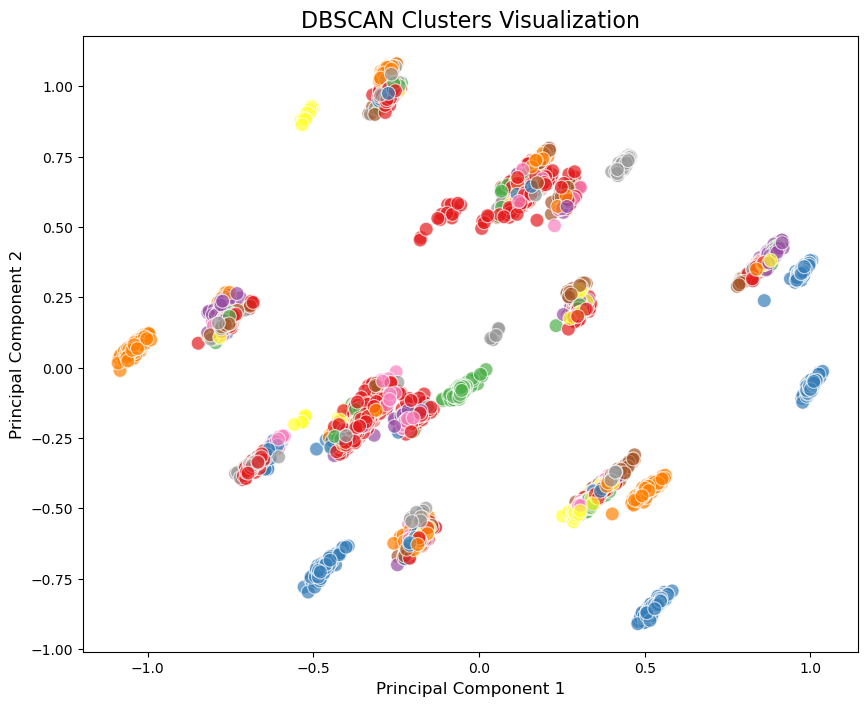

In [88]:
df_movies['dbscan_clusters'] = dbscan_model.labels_
df_movies['dbscan_clusters'].value_counts()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

df_movies['dbscan_clusters'] = dbscan_model.fit_predict(df_scaled)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_movies['pca1'] = df_pca[:, 0]
df_movies['pca2'] = df_pca[:, 1]

plt.figure(figsize=(10, 8))

sns.scatterplot(data=df_movies, x='pca1', y='pca2', hue='dbscan_clusters', palette='Set1', s=100, alpha=0.7, edgecolor='w', legend=None)

plt.title('DBSCAN Clusters Visualization', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.show()

In [96]:
import random

def recommend_movie(movie_name: str):
    movie_name = movie_name.lower()

    df_movies['title_lower'] = df_movies['title'].astype(str).str.lower()

    movie = df_movies[df_movies['title_lower'].str.contains(movie_name, na=False)]

    if not movie.empty:
        cluster = movie['dbscan_clusters'].values[0]

        cluster_movies = df_movies[df_movies['dbscan_clusters'] == cluster]

        if len(cluster_movies) >= 5:
            recommended_movies = random.sample(list(cluster_movies.index), 5)
        else:
            recommended_movies = list(cluster_movies.index)

        print('--- We can recommend you these movies ---')
        for m in recommended_movies:
            print(df_movies.loc[m, 'title'])
    else:
        print('Movie not found in the database.')


In [97]:
s = input('Input movie name: ')
print("\n\n")
recommend_movie(s)

Input movie name:  titanic





--- We can recommend you these movies ---
Before I Wake
We the Animals
Ouija: Origin of Evil
Get on Up
The Rental


In [25]:
import pandas as pd

df_clustered = pd.read_csv("clustered_movies.csv")
df_clustered.head(10)  


,title,dbscan_clusters
0,Five Came Back: The Reference Films,0
1,Taxi Driver,1
2,Deliverance,1
3,Monty Python and the Holy Grail,-1
4,The Dirty Dozen,-1
5,Monty Python's Flying Circus,2
6,Life of Brian,3
7,Dirty Harry,4
8,Bonnie and Clyde,5
9,The Blue Lagoon,6
